In [357]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from dataclasses import dataclass
import pyclothoids

plt.rcParams['figure.dpi'] = 200

In [358]:
@dataclass
class Curve:
    x: float
    y: float
    k0: float
    k1: float

In [359]:
# Based on `kurbo` library
def spiro(k0, k1):
    t1_1 = k0
    t1_2 = 0.5 * k1
    t2_2 = t1_1 * t1_1
    t2_3 = 2.0 * (t1_1 * t1_2)
    t2_4 = t1_2 * t1_2
    t3_4 = t2_2 * t1_2 + t2_3 * t1_1
    t3_6 = t2_4 * t1_2
    t4_4 = t2_2 * t2_2
    t4_5 = 2.0 * (t2_2 * t2_3)
    t4_6 = 2.0 * (t2_2 * t2_4) + t2_3 * t2_3
    t4_7 = 2.0 * (t2_3 * t2_4)
    t4_8 = t2_4 * t2_4
    t5_6 = t4_4 * t1_2 + t4_5 * t1_1
    t5_8 = t4_6 * t1_2 + t4_7 * t1_1
    t5_10 = t4_8 * t1_2
    t6_6 = t4_4 * t2_2
    t6_7 = t4_4 * t2_3 + t4_5 * t2_2
    t6_8 = t4_4 * t2_4 + t4_5 * t2_3 + t4_6 * t2_2
    t6_9 = t4_5 * t2_4 + t4_6 * t2_3 + t4_7 * t2_2
    t6_10 = t4_6 * t2_4 + t4_7 * t2_3 + t4_8 * t2_2
    t7_8 = t6_6 * t1_2 + t6_7 * t1_1
    t7_10 = t6_8 * t1_2 + t6_9 * t1_1
    t8_8 = t6_6 * t2_2
    t8_9 = t6_6 * t2_3 + t6_7 * t2_2
    t8_10 = t6_6 * t2_4 + t6_7 * t2_3 + t6_8 * t2_2
    t9_10 = t8_8 * t1_2 + t8_9 * t1_1
    t10_10 = t8_8 * t2_2
    
    u = 1.
    u -= (1. / 24.) * t2_2 + (1. / 160.) * t2_4
    u += (1. / 1920.) * t4_4 + (1. / 10752.) * t4_6 + (1. / 55296.) * t4_8
    u -= (1. / 322560.) * t6_6 + (1. / 1658880.) * t6_8 + (1. / 8110080.) * t6_10
    u += (1. / 92897280.) * t8_8 + (1. / 454164480.) * t8_10
    u -= 2.4464949595157930e-11 * t10_10
    
    v = (1. / 12.) * t1_2
    v -= (1. / 480.) * t3_4 + (1. / 2688.) * t3_6
    v += (1. / 53760.) * t5_6 + (1. / 276480.) * t5_8 + (1. / 1351680.) * t5_10
    v -= (1. / 11612160.) * t7_8 + (1. / 56770560.) * t7_10
    v += 2.4464949595157932e-10 * t9_10
    
    return u, v

def spiro_n(k0, k1):
    accuracy = 1.0e-12

    c1 = np.abs(k1);
    c0 = np.abs(k0) + 0.5 * c1
    est_err_raw = 0.006 * c0 * c0 + 0.029 * c1
    if est_err_raw**6 < accuracy:
        return spiro(k0, k1)
    else:
        n = int(np.ceil(est_err_raw / accuracy**(1.0 / 6.0)))

        s1s0 = 1.0 / n

        px = 0.0
        py = 0.0

        # s0 = -0.5, s1 = -0.5 + s1s0, s = (s0 + s1) * 0.5
        s = -0.5 + 0.5 * s1s0

        for i in range(n):
            (u, v) = spiro(s1s0 * (k0 + k1 * s), s1s0**2 * k1)

            theta = k0 * s + 0.5 * k1 * s**2
            tc, ts = np.cos(theta), np.sin(theta)

            px += tc * u - ts * v
            py += tc * v + ts * u

            s += s1s0
        
        return (px * s1s0, py * s1s0)

def eval_euler(s0, s1, u):
    k0 = u[1]
    k1 = u[2]

    s1s0 = s1 - s0
    s = (s0 + s1) * 0.5
    u, v = spiro_n(s1s0 * (k0 + k1 * s), s1s0**2 * k1)
    theta = k0 * s + 0.5 * k1 * s**2
    tc, ts = np.cos(theta), np.sin(theta)
    x = s1s0 * (tc * u - ts * v)
    y = s1s0 * (tc * v + ts * u)

    return x, y
    
def fit_euler(th0, th1):
    k1_old = 0
    e_old = th1 - th0
    k0 = th0 + th1
    k1 = 6 * (1 - ((.5 / np.pi) * k0) ** 3) * e_old
    for i in range(10):
        x, y = spiro(k0, k1)
        e = (th1 - th0) + 2 * np.arctan2(y, x) - .25 * k1
        if abs(e) < 1e-9:
            break
        k1_old, e_old, k1 = k1, e, k1 + (k1_old - k1) * e / (e - e_old)
        
    return k0, k1

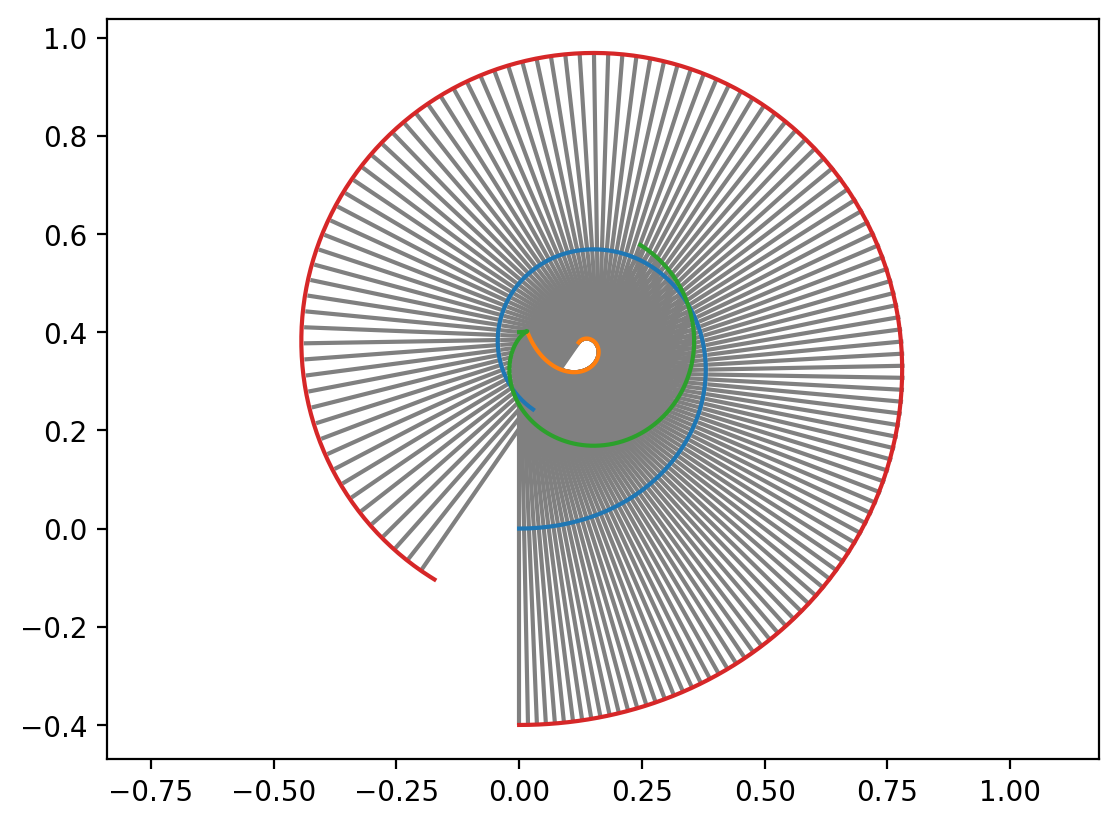

In [360]:
ds = 0.01
s = 0.0
L = 1.4

n = int(L / ds)

def spiral(t0, t1, k0, k1, offset=0.0):
    x = []
    y = []

    xn = 0.0
    yn = 0.0

    t = t0
    while t <= t1:
        curvature = k0 + k1 * t
        phi = k1 * t**2 / 2.0 + k0 * t

        x.append(xn - offset * np.sin(phi))
        y.append(yn + offset * np.cos(phi))

        darc = ds

        cusp = np.abs(1.0 - offset * curvature)
        darc = min(1.0 / cusp, 1.0) * ds

        xk, yk = eval_euler(t, t+darc, [0.0, k0, k1])
        
        xn += xk # darc * np.cos(phi)
        yn += yk # darc * np.sin(phi)

        t += darc

    return [x, y]

def spiral_evolute(k0, k1, offset=0.0):
    x = []
    y = []

    xn = 0.0
    yn = 0.0

    for i in range(n):
        t = (i * ds)
    
        phi = k1 * t**2 / 2.0 + k0 * t

        curvature = k0 + k1 * t
        p = 0.0

        if curvature != 0.0 and 1.0 < offset * curvature:
            p = 1.0 / curvature
    
            x.append(xn - p * np.sin(phi))
            y.append(yn + p * np.cos(phi))
        
        xn += ds * np.cos(phi)
        yn += ds * np.sin(phi)

    return [x, y]

def spiral_offset_lines(k0, k1, offset):
    xn = 0.0
    yn = 0.0

    lines = np.empty(n, dtype=object)

    for i in range(n):
        t = (i * ds)
        phi = k1 * t**2 / 2.0 + k0 * t

        ox = -offset * np.sin(phi)
        oy = offset * np.cos(phi)
        x0 = xn 
        y0 = yn

        x1 = x0 + ox
        y1 = y0 + oy;

        lines[i] = [(x0, y0), (x1, y1)]
        
        xn += ds * np.cos(phi)
        yn += ds * np.sin(phi)

    return LineCollection(lines, linestyle = "solid", colors="gray")

def curve_length(x, y):
    length = 0.0
    for i in range(1, len(x)):
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]
        darc = np.sqrt(dx * dx + dy * dy)

        length += darc
    return length

k0 = 2.0
k1 = 3.0
phi0 = 0.0

[x0, y0] = spiral(0.0, L, k0, k1, offset = 0.0)
[x1, y1] = spiral(0.0, L, k0, k1, offset = 0.4)
[x2, y2] = spiral(0.0, L, k0, k1, offset = -0.4)
[xe0, ye0] = spiral_evolute(k0, k1, offset = 0.4)
normals0 = spiral_offset_lines(k0, k1, offset = 0.4)
normals1 = spiral_offset_lines(k0, k1, offset = -0.4)

#print(curve_length(x0, y0, 0.0))
# print(curve_length(x1, y1, 0.4))

fig, ax = plt.subplots()
ax.add_collection(normals0)
ax.add_collection(normals1)
ax.plot(x0, y0)
ax.plot(xe0, ye0)
ax.plot(x1, y1)
ax.plot(x2, y2)
ax.axis('equal')
plt.show()

1.5707963267948966 0.0
0.9899898220018533


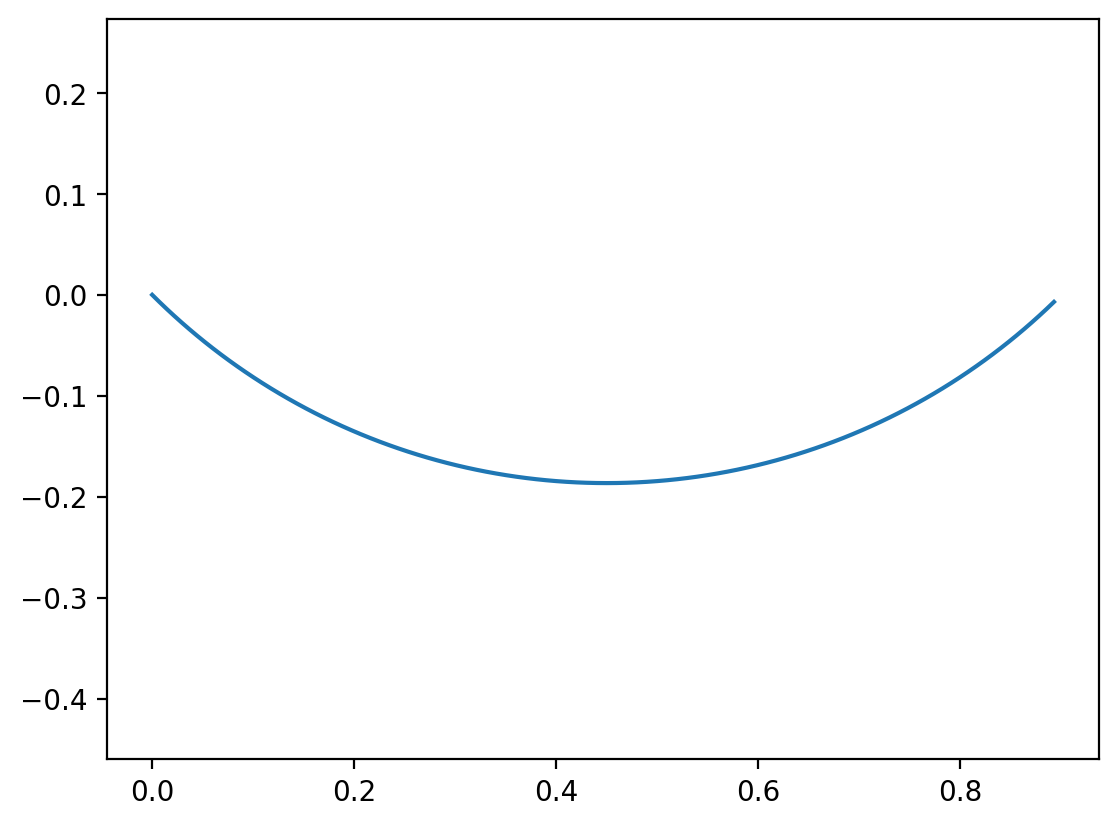

In [361]:
k0, k1 = fit_euler(np.pi /4.0, np.pi /4.0)
print(k0, k1)

[x0, y0] = spiral(t0=-0.5, t1=0.5, k0=k0, k1=k1, offset = 0.0)
print(curve_length(x0, y0))

fig, ax = plt.subplots()
ax.plot(x0, y0)
ax.axis('equal')
plt.show()

In [362]:
@dataclass
class ParamG1:
    x: float
    y: float
    phi: float

@dataclass
class ParamG2:
    x: float
    y: float
    phi: float
    k: float

def fresnel_cs(a, b, c, n):
    fc = []
    fs = []

    if np.abs(a) < 0.01:
        nkk = n + 12 + 2

        # evalXYazero
        x0 = []
        y0 = []

        sb = np.sin(b)
        cb = np.cos(b)
        b2 = b**2

        if np.abs(b) < 1.0e-3:
            x0.append(1.0-(b2/6.0)*(1.0-(b2/20.0)*(1.0-(b2/42.0))))
            y0.append((b/2)*(1-(b2/12)*(1-(b2/30))))
        else:
            x0.append(sb/b)
            y0.append((1-cb)/b)
        
        m = np.floor(2*b)
        if m >= n:
            m = n - 1
        if m < 1:
            m = 1
        for k in range(1, m):
            x0.append((sb-k*y0[k-1])/b)
            y0.append((k*x0[k-1]-cb)/b)


def fit_g1(param0: ParamG1, param1: ParamG1):
    dx = param1.x - param0.x
    dy = param1.y - param0.y
    d = np.sqrt(dx**2 + dy**2)
    phi = np.arctan2(dy, dx)
    phi0 = param0.phi - phi
    phi1 = param1.phi - phi

    print(phi0, phi1)

    dphi = phi1 - phi0
    x = phi0 / np.pi
    y = phi1 / np.pi
    xy = x * y
    y *= y
    x *= x
    a = (phi0+phi1) * (2.989696028701907 + xy * (0.716228953608281 + xy * -0.458969738821509) + (-0.502821153340377 + xy * 0.261062141752652) * (x + y) - 0.045854475238709 * (x*x+y*y)) 

    # newton
    g = 0

def fit_g2(param0: ParamG2, param1: ParamG2):
    dx = param1.x - param0.x
    dy = param1.y - param0.y
    d = np.sqrt(dx**2 + dy**2)
    phi = np.arctan2(dy, dx)
    lmda = d / 2.0
    


p0 = ParamG1(-1.0, 0.0, np.pi / 3.0)
p1 = ParamG1(1.0, 0.0, -np.pi / 2.0)

fit_g1(p0, p1)

1.0471975511965976 -1.5707963267948966


(0.0, 1.0, 0.0, -1.0000000000000002, 2.873106197358048e-16, 1.5707963267948966)
(0.0, 1.0, 0.0, 0.0, -2.6393777662199636, 0.5235692063579954)
(0.5167586549735523, 0.9374523777537165, -0.36175933744872146, -1.3818969223387254, -1.1474518539855829e-15, 0.613126520655042)
(0.9374523777537166, 0.5167586549735522, -1.209036989346175, -1.3818969223387265, 2.6393777662199662, 0.5235692063579954)


(-0.05000000000000002, 1.0500000000000003, -0.05000000000000024, 1.05)

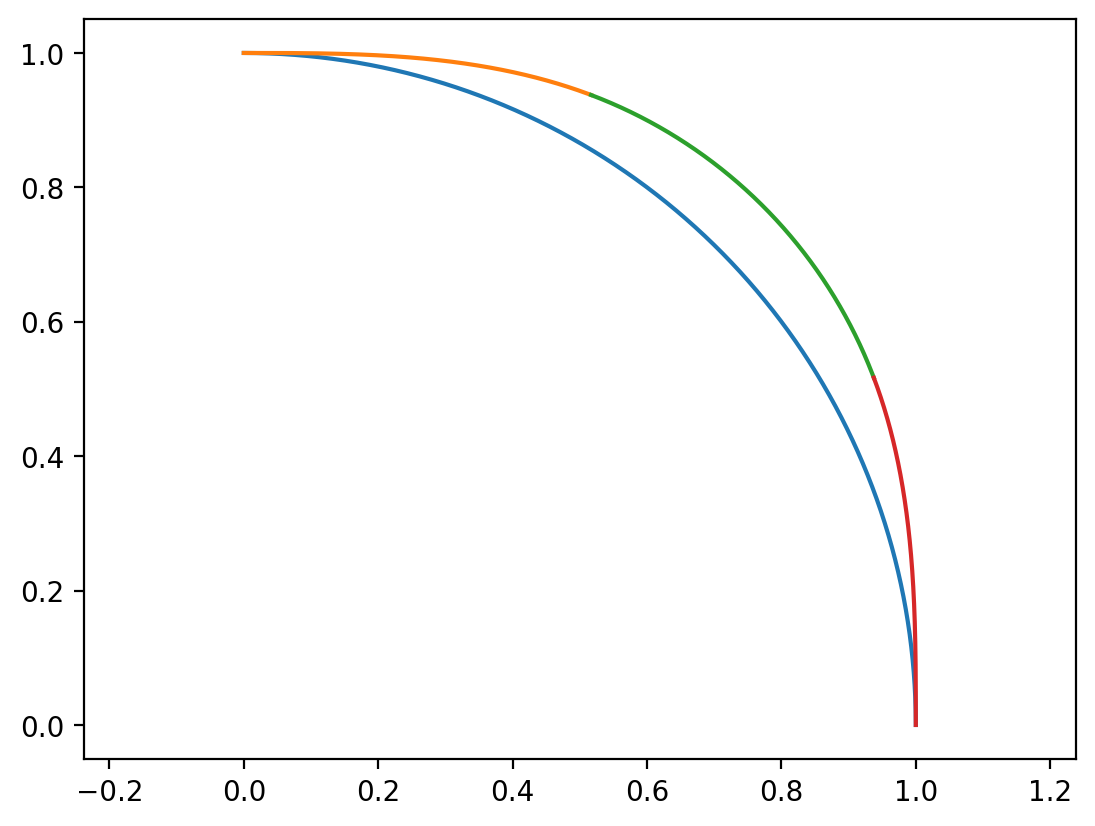

In [363]:
from pyclothoids import Clothoid, SolveG2

clothoid0 = Clothoid.G1Hermite(0, 1, 0.0, 1, 0, -np.pi / 2)
clothoid_list = SolveG2(0, 1, 0.0, 0.0, 1, 0, -np.pi / 2, 0.0)

fig, ax = plt.subplots()

ax.plot(*clothoid0.SampleXY(500))
print(clothoid0.Parameters)

# x, y, phi, k0, k1, L
for i in clothoid_list:
    print(i.Parameters)
    ax.plot( *i.SampleXY(500) )

ax.axis('equal')

